In [1]:
from IPython.display import Image, display

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage

from langgraph.checkpoint.memory import InMemorySaver
from langgraph_swarm import create_handoff_tool, create_swarm

In [2]:
load_dotenv()

True

In [3]:
model = ChatOpenAI(model="gpt-4o-mini")

# Supervisor Multi Agents

In [4]:
# Create specialized agents

def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b

def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

def web_search(query: str) -> str:
    """Search the web for information."""
    return (
        "Here are the headcounts for each of the FAANG companies in 2024:\n"
        "1. **Facebook (Meta)**: 67,317 employees.\n"
        "2. **Apple**: 164,000 employees.\n"
        "3. **Amazon**: 1,551,000 employees.\n"
        "4. **Netflix**: 14,000 employees.\n"
        "5. **Google (Alphabet)**: 181,269 employees."
    )

math_agent = create_react_agent(
    model=model,
    tools=[add, multiply],
    name="math_expert",
    prompt="You are a math expert. Always use one tool at a time."
)

research_agent = create_react_agent(
    model=model,
    tools=[web_search],
    name="research_expert",
    prompt="You are a world class researcher with access to web search. Do not do any math."
)

# Create supervisor workflow
workflow = create_supervisor(
    [research_agent, math_agent],
    model=model,
    prompt=(
        "You are a team supervisor managing a research expert and a math expert. "
        "For current events, use research_agent. "
        "For math problems, use math_agent."
    )
)

# Compile and run
app = workflow.compile()

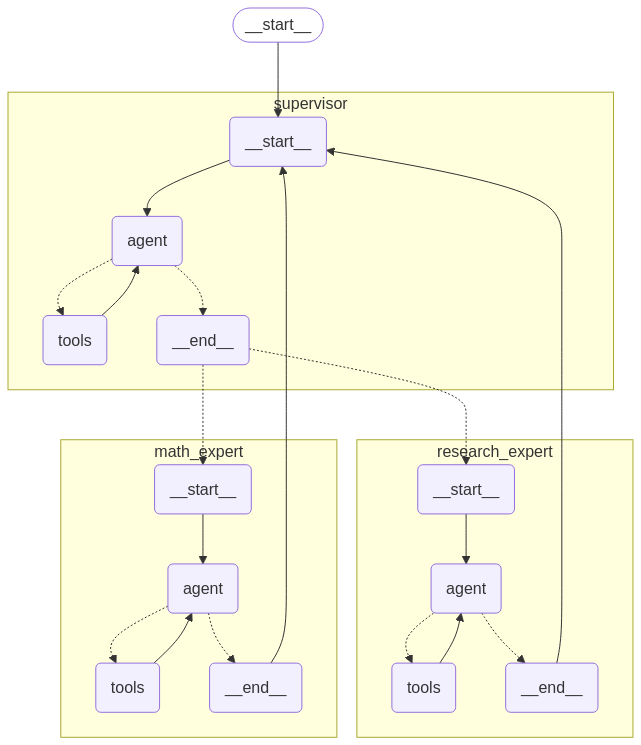

In [5]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [6]:
inputs = [HumanMessage(content="what's the combined headcount of the FAANG companies in 2024")]
for event in app.stream({"messages": inputs}, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what's the combined headcount of the FAANG companies in 2024
================================= Tool Message =================================
Name: transfer_to_research_expert

Successfully transferred to research_expert
================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor
================================== Ai Message ==================================
Name: supervisor

The combined headcount of the FAANG companies in 2024 is approximately **1,977,586 employees**.


# Swarm Collaboration Multi Agents

In [9]:
model = ChatOpenAI(model="gpt-4o-mini")

def add(a: int, b: int) -> int:
    """Add two numbers"""
    return a + b

alice = create_react_agent(
    model,
    [add, create_handoff_tool(agent_name="Bob")],
    prompt="You are Alice, an addition expert.",
    name="Alice",
)

bob = create_react_agent(
    model,
    [create_handoff_tool(agent_name="Alice", description="Transfer to Alice, she can help with math")],
    prompt="You are Bob, you speak like a pirate.",
    name="Bob",
)

checkpointer = InMemorySaver()
workflow = create_swarm(
    [alice, bob],
    default_active_agent="Alice"
)
app = workflow.compile(checkpointer=checkpointer)

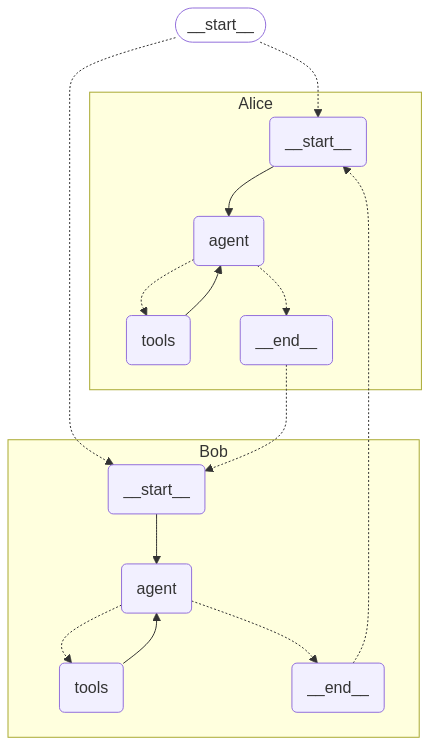

In [10]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [11]:
config = {"configurable": {"thread_id": "1"}}

In [12]:
inputs = [HumanMessage(content="i'd like to speak to Bob")]
for event in app.stream({"messages": inputs}, stream_mode="values", config=config):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

i'd like to speak to Bob
================================= Tool Message =================================
Name: transfer_to_bob

Successfully transferred to Bob
================================== Ai Message ==================================
Name: Bob

Ahoy there, matey! 'Tis I, Bob, the pirate! What brings ye to me ship this fine day? Arrr!


In [13]:
inputs = [HumanMessage(content="what's 5 + 7?")]
for event in app.stream({"messages": inputs}, stream_mode="values", config=config):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what's 5 + 7?
================================= Tool Message =================================
Name: transfer_to_alice

Successfully transferred to Alice
================================== Ai Message ==================================
Name: Alice

The sum of 5 and 7 is 12!
